In [ ]:
import pandas as pd, numpy as np                                # pandas — таблицы (DataFrame), numpy — числовые операции/типы
from scipy import stats                                          # scipy.stats — набор статистических функций (в этом скрипте не обязателен, но оставим для единообразия)
import matplotlib.pyplot as plt                                  # matplotlib — графики (в этом скрипте графиков нет; импорт для будущих ячеек)
from IPython.display import display, HTML                        # display/HTML — «красивый» вывод таблиц и заголовков в ноутбуке
import warnings; warnings.filterwarnings("ignore")               # скрываем предупреждения, чтобы они не отвлекали от сути

DATA_PATH = "Automobile.csv"                                     # строка с путём к вашему CSV-файлу (можно заменить на свой)
df = pd.read_csv(DATA_PATH)                                      # загружаем CSV в DataFrame (строки=наблюдения, столбцы=признаки)

# --- Форма и типы ---
display(HTML("<h3>Форма датасета</h3>"))                         # показываем заголовок раздела в HTML (более крупный и заметный)
display(pd.DataFrame({"Строк": [df.shape[0]],                    # создаём мини-таблицу с числом строк (df.shape[0])
                      "Столбцов": [df.shape[1]]}))               # и числом столбцов (df.shape[1]) — выводим через display

display(HTML("<h3>Типы данных по столбцам</h3>"))                # заголовок блока про типы данных (int, float, object и т.д.)
display(df.dtypes.to_frame("Тип"))                               # превращаем dtypes в DataFrame с одной колонкой "Тип" и показываем

display(HTML("<h3>Первые 3 строки</h3>"))                        # заголовок блока предпросмотра данных
display(df.head(3))                                              # выводим первые 3 строки — чтобы увидеть, как выглядят значения

# --- Пропуски и уникальные ---
missing = pd.DataFrame({                                         # собираем таблицу с пропусками
    "Пропусков": df.isna().sum(),                                # для каждого столбца считаем количество NaN
    "Пропуски, %": (df.isna().mean()*100).round(2)               # и долю пропусков в процентах, округлённую до 2 знаков
}).sort_values("Пропуски, %", ascending=False)                   # сортируем столбцы по убыванию доли пропусков (с проблемных сверху)

display(HTML("<h3>Пропуски по столбцам</h3>"))                   # заголовок раздела про пропуски
display(missing)                                                 # показываем таблицу с пропусками

display(HTML("<h3>Число уникальных значений</h3>"))              # заголовок раздела про уникальные значения
display(                                                          # выводим таблицу «столбец -> сколько уникальных значений»
    df.nunique(dropna=True)                                      # считаем число уникальных (NaN не учитываем)
      .sort_values(ascending=False)                              # сортируем по убыванию — самые «разнообразные» наверху
      .to_frame("Уникальных")                                    # превращаем в DataFrame с колонкой «Уникальных»
)

# --- Разделение на числовые и категориальные ---
num_cols = df.select_dtypes(include=np.number).columns.tolist()  # выбираем названия только числовых столбцов (int/float)
cat_cols = [c for c in df.columns if c not in num_cols]          # всё остальное считаем категориальными/текстовыми/датами

display(HTML("<h3>Типизация признаков</h3>"))                    # заголовок с описанием состава признаков
display(pd.DataFrame({                                           # выводим одну строку с перечислением списков столбцов
    "Числовые столбцы": [", ".join(num_cols) if num_cols else "—"],           # перечисление числовых колонок через запятую
    "Категориальные/текстовые столбцы": [", ".join(cat_cols) if cat_cols else "—"]  # перечисление категориальных колонок
}))

# --- Доп. табл. 1: Технический профиль столбцов ---
mem = df.memory_usage(deep=True)                                 # оцениваем память, занимаемую каждым столбцом (deep=True учитывает строки)
examples = df.astype(str).apply(                                 # делаем пример значения для каждого столбца
    lambda s: s.dropna().iloc[0] if s.dropna().shape[0] else "—" # берём первое непустое значение; если всё пусто — ставим «—»
)

tech_profile = pd.DataFrame({                                    # собираем «техпаспорт» на каждый столбец
    "Тип": df.dtypes.astype(str),                                # строковое представление типа данных
    "Не-NaN": df.notna().sum(),                                  # количество непустых значений
    "Пропусков": df.isna().sum(),                                # количество пропусков
    "Пропуски, %": (df.isna().mean()*100).round(2),              # доля пропусков в %
    "Уникальных": df.nunique(dropna=True),                       # число уникальных значений (без учёта NaN)
    "Память, байт": mem,                                         # потребление памяти в байтах
    "Пример значения": examples                                  # пример реального значения (для ориентира формата)
}).sort_values(["Пропуски, %","Уникальных"],                     # сортируем: сначала больше пропусков, затем больше уникальных
               ascending=[False, False])

display(HTML("<h3>Технический профиль столбцов</h3>"))           # заголовок раздела «техпрофиль»
display(tech_profile)                                            # выводим техпрофиль — очень полезно для первичного аудита качества

# --- Доп. табл. 2: Короткая сводка по числовым + категориальные TOP ---
if num_cols:                                                     # если в наборе есть числовые столбцы — считаем для них описательную статистику
    desc_num = df[num_cols].describe(percentiles=[.05,.25,.5,.75,.95]).T  # .describe + расширенные перцентили; .T — «метрики в колонках»
    desc_num["IQR"] = desc_num["75%"] - desc_num["25%"]          # межквартильный размах (robust-наблюдение разброса)
    desc_num["Асимметрия"] = df[num_cols].skew()                 # коэффициент асимметрии (скошенность распределения)
    desc_num["Эксцесс"] = df[num_cols].kurt()                    # эксцесс (островершинность; kurtosis-3)
    display(HTML("<h3>Описательная статистика (числовые)</h3>")) # заголовок блока с числовой сводкой
    display(desc_num.round(4))                                   # выводим с округлением до 4 знаков — читаемее

if cat_cols:                                                     # если есть категориальные/текстовые столбцы — берём топовые категории
    top_rows = []                                                # сюда сложим строковые сводки по каждому категориальному признаку
    for c in cat_cols:                                           # идём по каждому категориальному столбцу
        vc = df[c].value_counts(dropna=True)                     # считаем частоты категорий (NaN игнорируем)
        if vc.shape[0] > 0:                                      # если колонка не пуста
            top = str(vc.index[0]);                              # название самой частой категории (т.н. «мода»)
            cnt = int(vc.iloc[0]);                               # её абсолютная частота (сколько строк)
            pct = round(cnt/len(df)*100, 2)                      # её доля от всех строк датасета, в процентах
            top_rows.append({"Столбец": c,                       # формируем строку-резюме для итоговой таблицы
                              "Топ категория": top,
                              "Частота": cnt,
                              "Доля, %": pct,
                              "Уникальных": int(df[c].nunique(dropna=True))})

    if top_rows:                                                 # если таблица с топами не пустая — выводим её
        top_table = pd.DataFrame(top_rows).sort_values("Доля, %", ascending=False)  # сортировка: самые доминирующие сверху
        display(HTML("<h3>Категориальные: доминирующие категории</h3>"))           # заголовок блока про доминирование
        display(top_table)                                       # показываем таблицу

,Строк,Столбцов
0,398,9


,Тип
name,object
mpg,float64
cylinders,int64
displacement,float64
horsepower,float64
weight,int64
acceleration,float64
model_year,int64
origin,object


,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,usa
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,usa
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,usa


,Пропусков,"Пропуски, %"
horsepower,6,1.51
name,0,0.00
mpg,0,0.00
cylinders,0,0.00
displacement,0,0.00
weight,0,0.00
acceleration,0,0.00
model_year,0,0.00
origin,0,0.00


,Уникальных
weight,351
name,305
mpg,129
acceleration,95
horsepower,93
displacement,82
model_year,13
cylinders,5
origin,3


,Числовые столбцы,Категориальные/текстовые столбцы
0,"mpg, cylinders, displacement, horsepower, weig...","name, origin"


,Тип,Не-NaN,Пропусков,"Пропуски, %",Уникальных,"Память, байт",Пример значения
horsepower,float64,392.0,6.0,1.51,93.0,3184,130.0
weight,int64,398.0,0.0,0.00,351.0,3184,3504
name,object,398.0,0.0,0.00,305.0,25908,chevrolet chevelle malibu
mpg,float64,398.0,0.0,0.00,129.0,3184,18.0
acceleration,float64,398.0,0.0,0.00,95.0,3184,12.0
displacement,float64,398.0,0.0,0.00,82.0,3184,307.0
model_year,int64,398.0,0.0,0.00,13.0,3184,70
cylinders,int64,398.0,0.0,0.00,5.0,3184,8
origin,object,398.0,0.0,0.00,3.0,21064,usa
Index,NaN,NaN,NaN,NaN,NaN,132,NaN


,count,mean,std,min,5%,25%,50%,75%,95%,max,IQR,Асимметрия,Эксцесс
mpg,398.0,23.5146,7.8160,9.0,13.000,17.500,23.0,29.000,37.030,46.6,11.50,0.4571,-0.5108
cylinders,398.0,5.4548,1.7010,3.0,4.000,4.000,4.0,8.000,8.000,8.0,4.00,0.5269,-1.3767
displacement,398.0,193.4259,104.2698,68.0,85.000,104.250,148.5,262.000,400.000,455.0,157.75,0.7196,-0.7466
horsepower,392.0,104.4694,38.4912,46.0,60.550,75.000,93.5,126.000,180.000,230.0,51.00,1.0873,0.6969
weight,398.0,2970.4246,846.8418,1613.0,1923.500,2223.750,2803.5,3608.000,4464.000,5140.0,1384.25,0.5311,-0.7855
acceleration,398.0,15.5681,2.7577,8.0,11.285,13.825,15.5,17.175,20.415,24.8,3.35,0.2788,0.4195
model_year,398.0,76.0101,3.6976,70.0,70.000,73.000,76.0,79.000,82.000,82.0,6.00,0.0115,-1.1812


,Столбец,Топ категория,Частота,"Доля, %",Уникальных
1,origin,usa,249,62.56,3
0,name,ford pinto,6,1.51,305


Скрипт 2 — Гистограммы + аппроксимации (Normal/Lognormal/Gamma/Exponential) и boxplot

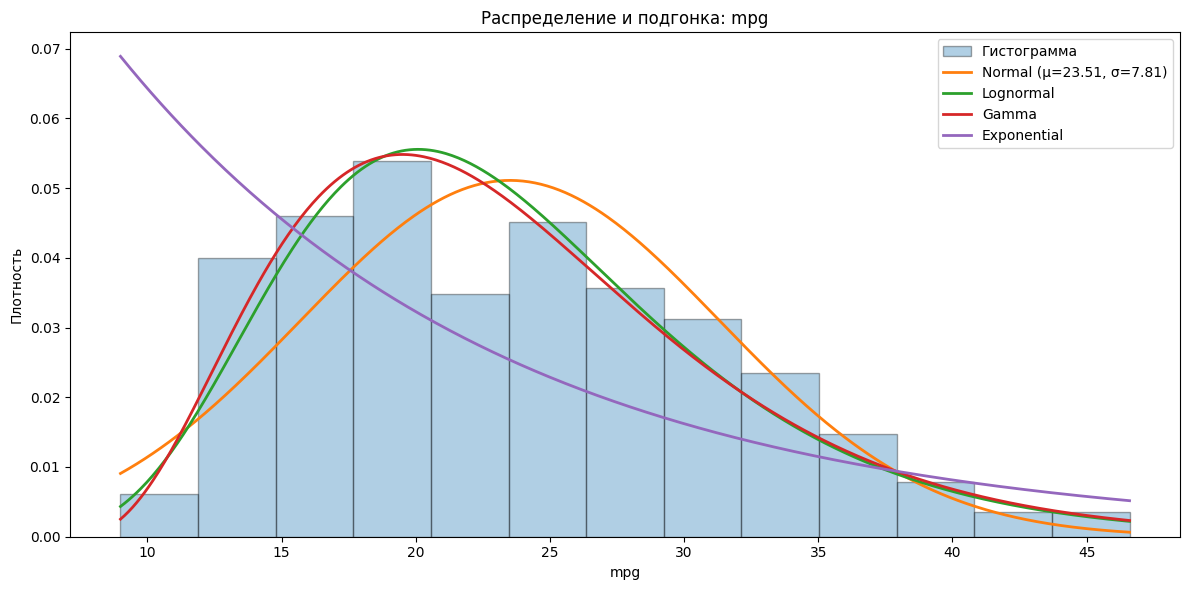

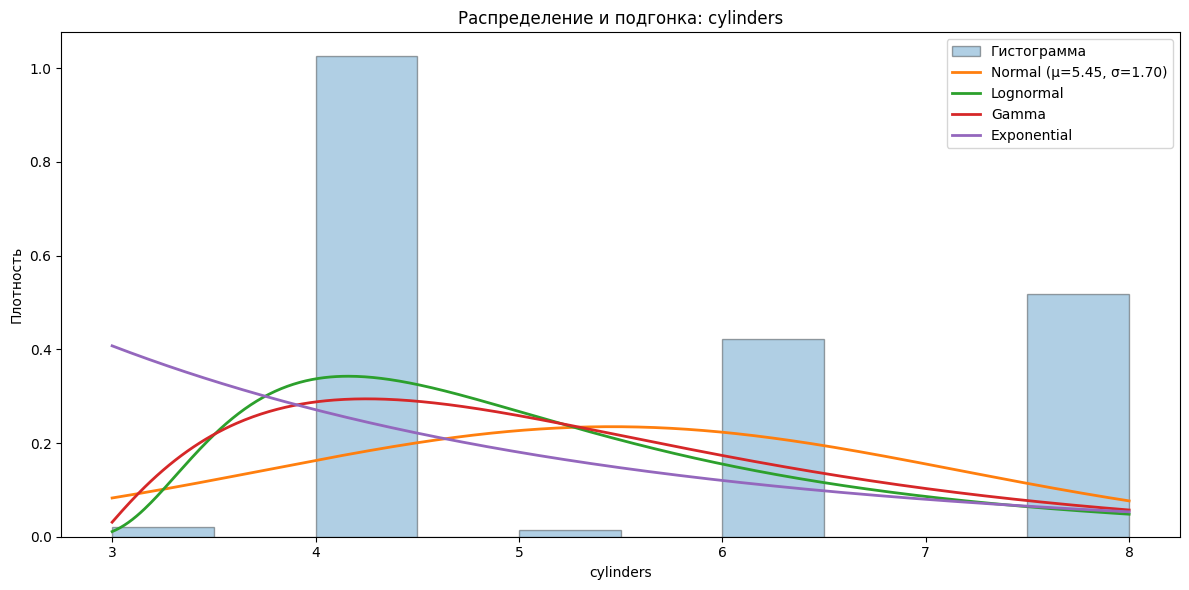

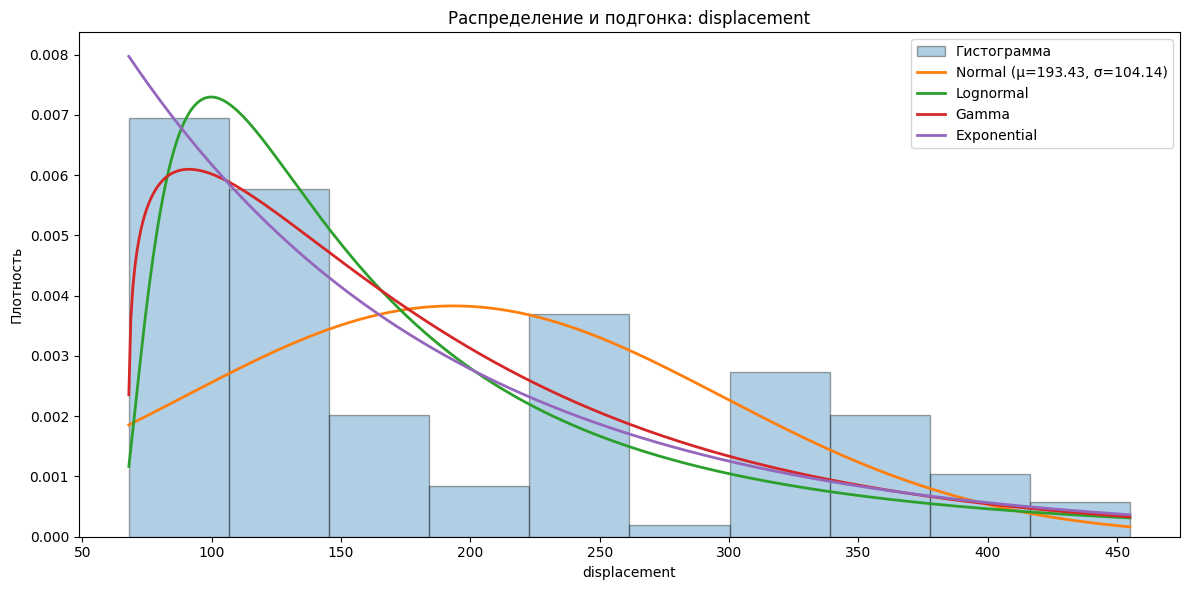

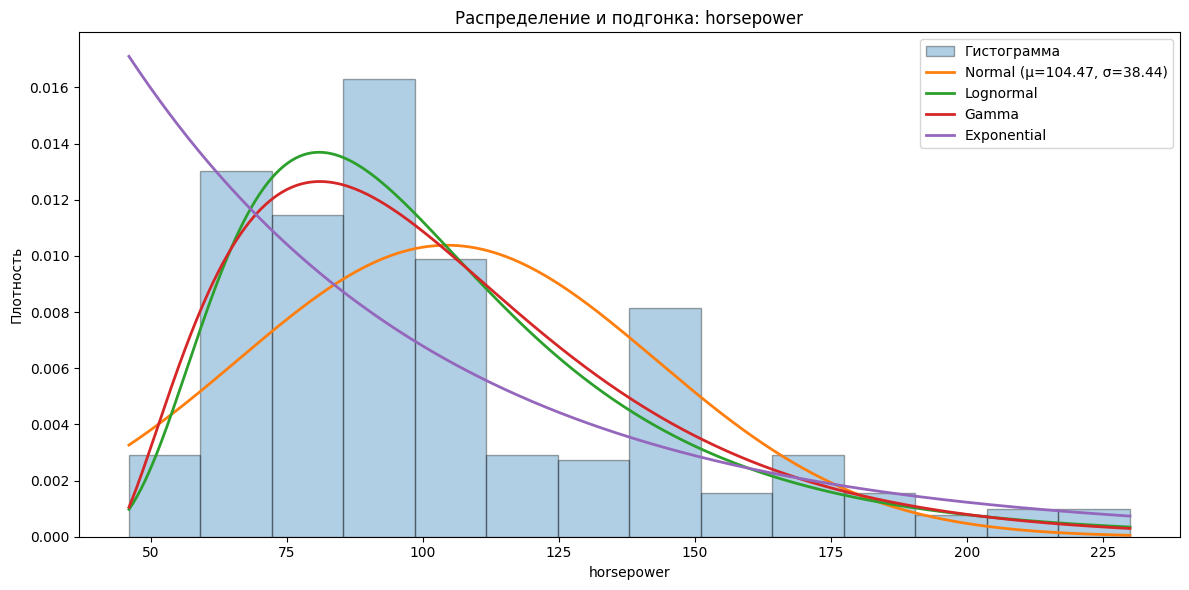

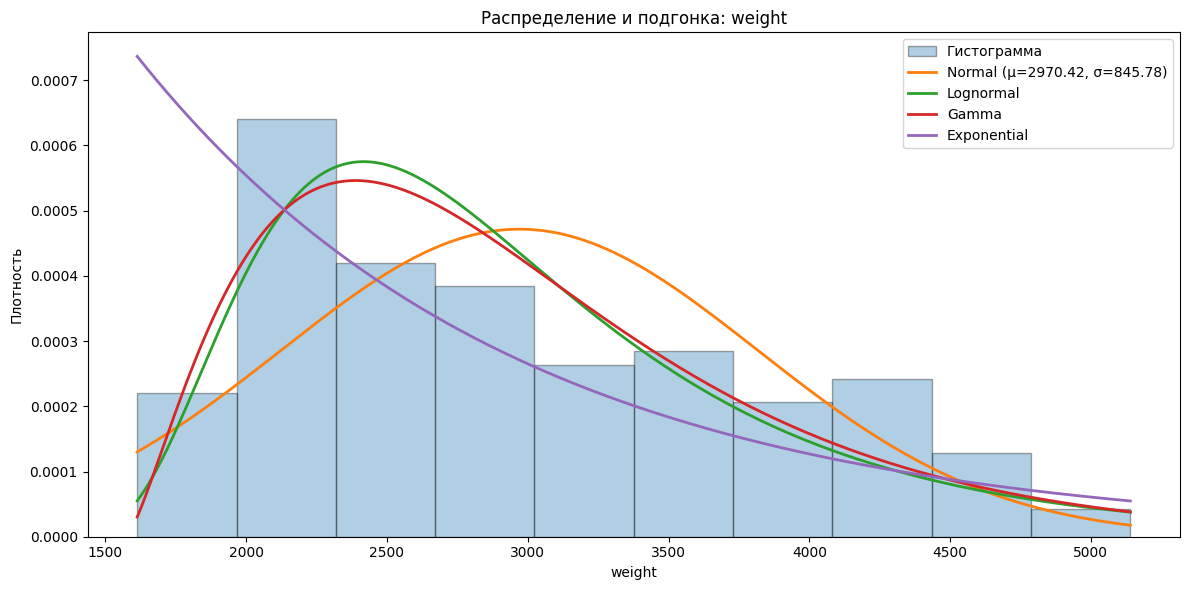

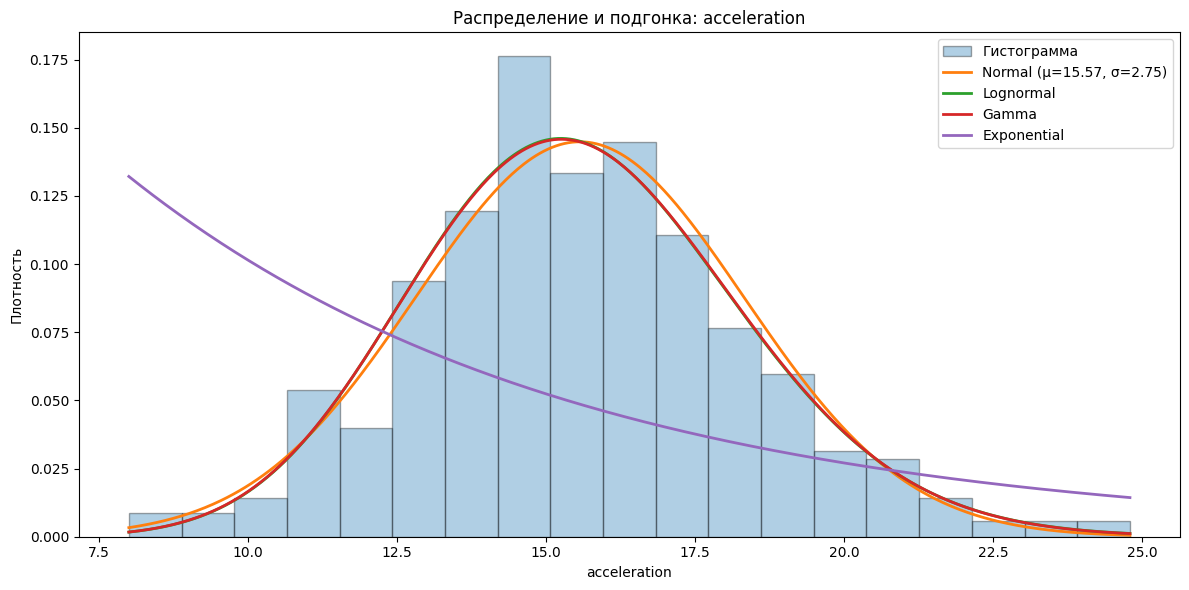

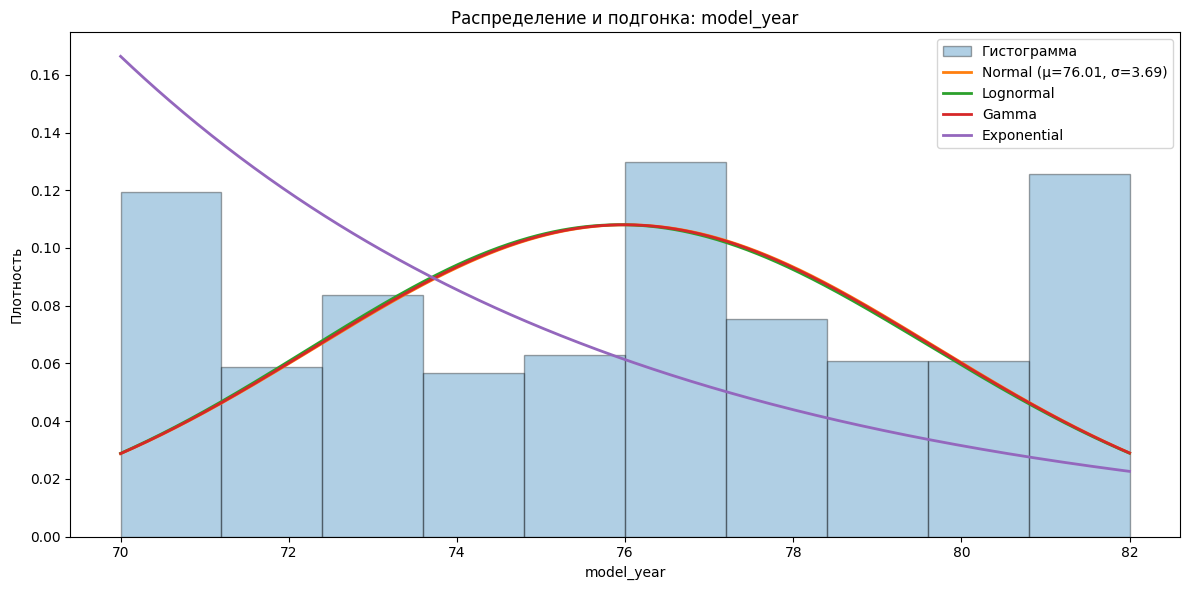

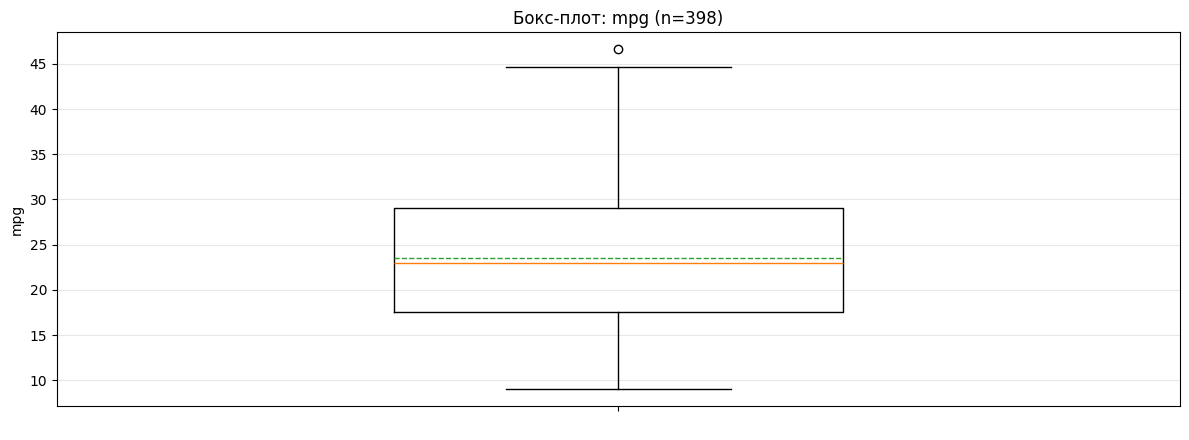

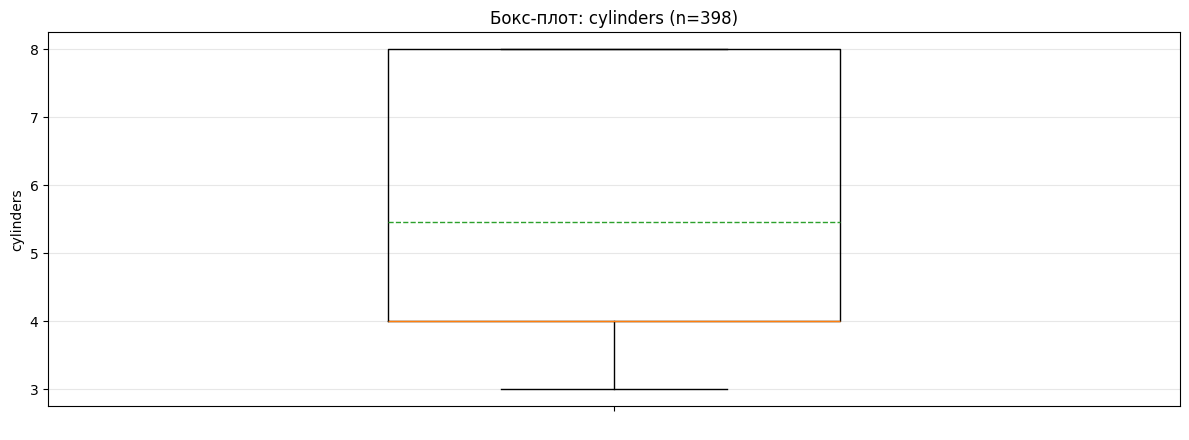

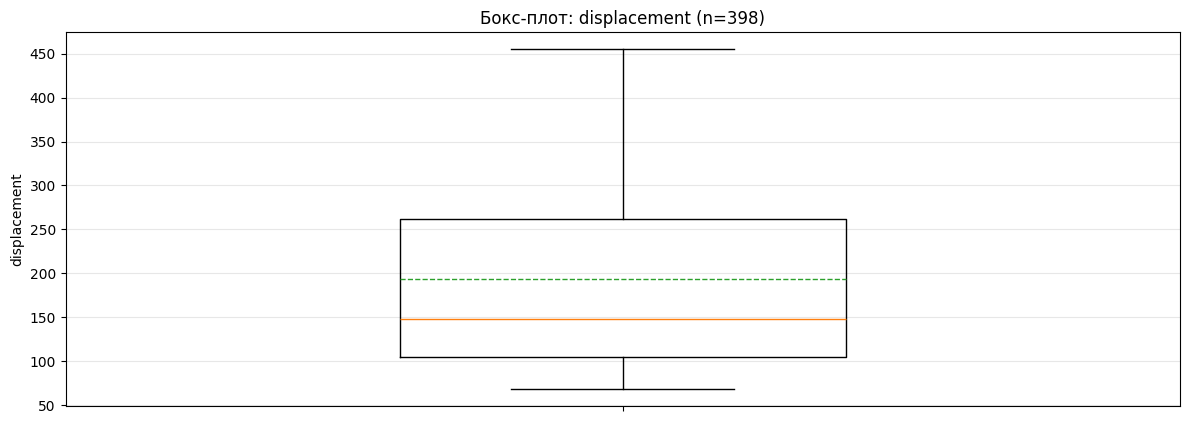

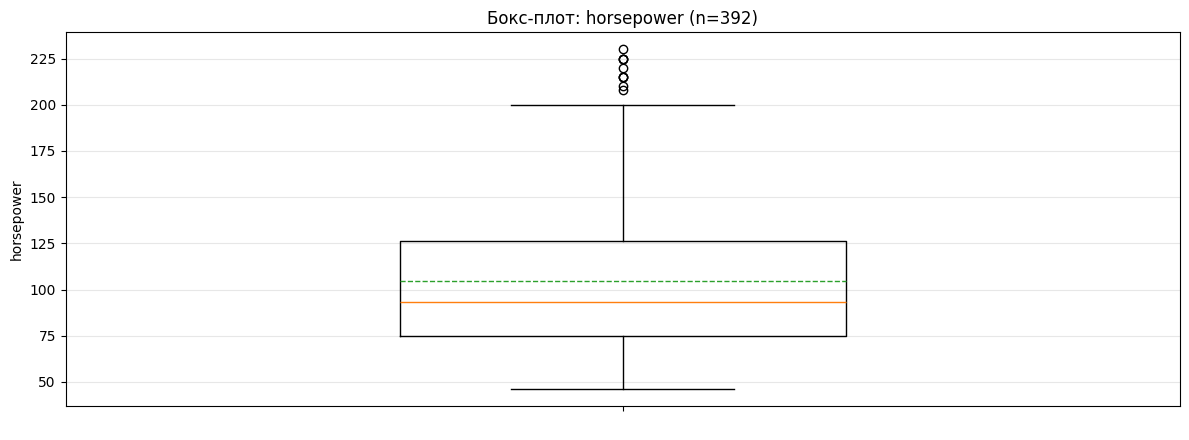

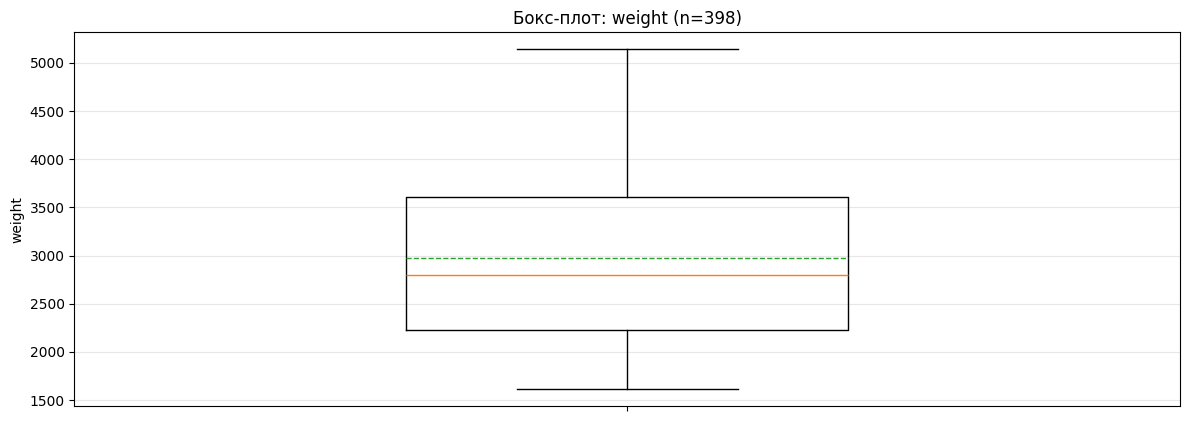

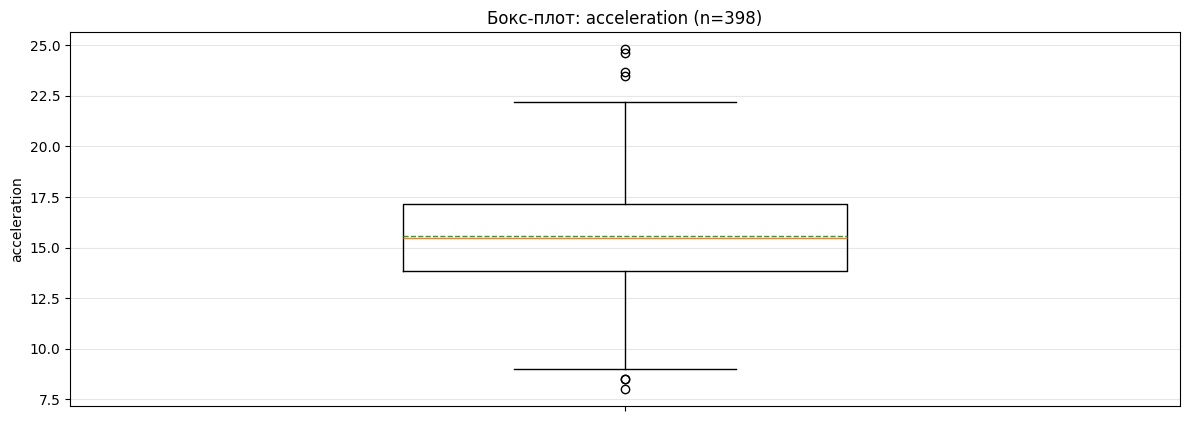

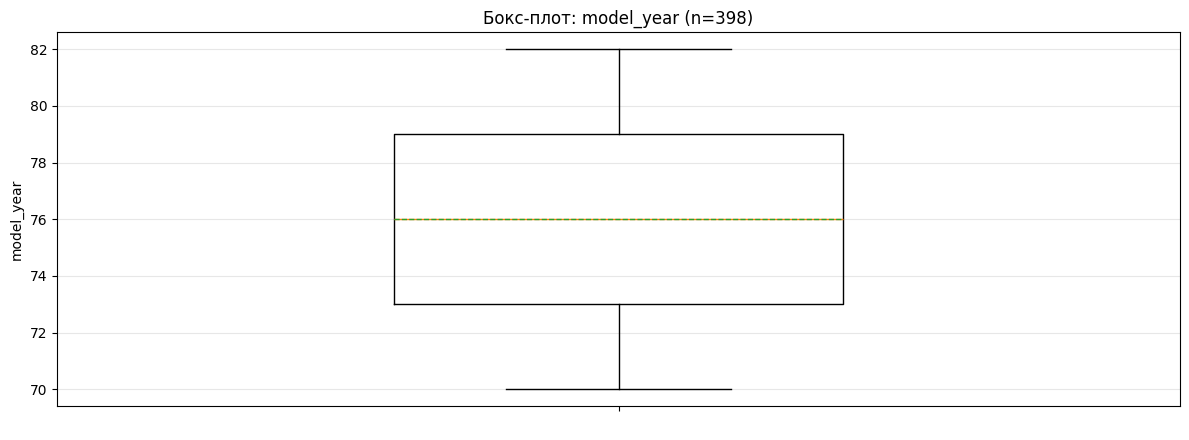

In [ ]:
# гарантируем, что список числовых колонок есть (если не запускали предыдущую ячейку)
num_cols = df.select_dtypes(include=np.number).columns.tolist() if 'num_cols' not in locals() else num_cols  # перечень числовых столбцов

# --- Для КАЖДОГО числового признака строим гистограмму + подгонку 4 распределений ---
for c in num_cols:                                                            # перебираем названия числовых столбцов
    x = df[c].dropna().values                                                 # вытаскиваем значения по столбцу и убираем пропуски (NaN)
    if x.size == 0:                                                           # если после очистки нет значений —
        continue                                                              # пропускаем такой столбец

    x_min, x_max = np.min(x), np.max(x)                                       # находим минимум и максимум для сетки по оси X
    if x_min == x_max:                                                        # если все значения одинаковые (разброс нулевой),
        x_min, x_max = x_min - 1, x_max + 1                                   # чуть расширяем диапазон, чтобы график не «сломался»

    grid = np.linspace(x_min, x_max, 500)                                     # создаём равномерную сетку для отрисовки теоретических кривых
    plt.figure(figsize=(12, 6))                                               # делаем РАСШИРЕННУЮ и БОЛЬШУЮ фигуру (шире и выше)

    plt.hist(x, bins="auto", density=True, alpha=.35, edgecolor="k", label="Гистограмма")  # рисуем гистограмму плотности с автоматическим числом бинов

    # ---- Нормальное распределение (Normal) ----
    try:                                                                      # оборачиваем в try на случай неустойчивой оценки
        m, s = stats.norm.fit(x)                                              # оцениваем параметры нормального распределения (μ, σ) методом ММП
        if np.isfinite(s) and s > 0:                                          # защищаемся от нулевой/NaN дисперсии
            plt.plot(grid, stats.norm.pdf(grid, m, s), lw=2,
                     label=f"Normal (μ={m:.2f}, σ={s:.2f})")                  # рисуем теоретическую плотность нормального закона
    except Exception as e:                                                    # если не получилось — пропускаем
        pass

    # ---- Распределения для положительных значений: Lognormal / Gamma / Exponential ----
    xp = x[x > 0]                                                             # выделяем только положительные наблюдения
    grid_pos = grid[grid > 0]                                                 # и положительную часть сетки (эти распределения определены на x>0)
    if xp.size > 0 and grid_pos.size > 0:                                     # проверяем, что есть данные и область определения
        # Lognormal
        try:
            sh, lo, sc = stats.lognorm.fit(xp)                                # оцениваем параметры логнормального распределения
            plt.plot(grid_pos, stats.lognorm.pdf(grid_pos, sh, lo, sc), lw=2,
                     label="Lognormal")                                       # рисуем логнормальную плотность
        except Exception as e:
            pass

        # Gamma
        try:
            a, lo, sc = stats.gamma.fit(xp)                                   # оцениваем параметры гамма-распределения
            plt.plot(grid_pos, stats.gamma.pdf(grid_pos, a, lo, sc), lw=2,
                     label="Gamma")                                           # рисуем гамма-плотность
        except Exception as e:
            pass

        # Exponential
        try:
            lo, sc = stats.expon.fit(xp)                                      # оцениваем параметры экспоненциального распределения
            plt.plot(grid_pos, stats.expon.pdf(grid_pos, lo, sc), lw=2,
                     label="Exponential")                                     # рисуем экспоненциальную плотность
        except Exception as e:
            pass

    plt.title(f"Распределение и подгонка: {c}")                               # заголовок графика с названием признака
    plt.xlabel(c)                                                             # подпись оси X — название столбца
    plt.ylabel("Плотность")                                                   # подпись оси Y — плотность
    plt.legend()                                                              # показываем легенду с названиями кривых
    plt.tight_layout()                                                        # аккуратно «упаковываем» в рамки фигуры
    plt.show()                                                                # отображаем график для текущего столбца

# --- Отдельные БОКС-ПЛОТЫ по каждой числовой переменной ---
for c in num_cols:                                                            # снова перебираем числовые столбцы
    v = df[c].dropna()                                                        # берём значения без пропусков
    if v.size == 0:                                                           # если пусто — пропускаем
        continue
    plt.figure(figsize=(12, 4.5))                                             # делаем широкий и достаточно высокий бокс-плот
    plt.boxplot(v, vert=True, showmeans=True, meanline=True,                  # рисуем boxplot; показываем среднее линией
                whis=1.5, widths=0.4)                                         # «усы» 1.5*IQR — классическое правило
    plt.title(f"Бокс-плот: {c} (n={len(v)})")                                 # заголовок с названием признака и объёмом данных
    plt.ylabel(c)                                                             # подпись оси Y — тот же признак
    plt.xticks([1], [" "])                                                    # отключаем подпись по оси X (одна «фиктивная» категория)
    plt.grid(True, axis='y', alpha=0.3)                                       # легкая сетка по Y для удобства чтения
    plt.tight_layout()                                                        # аккуратная компоновка элементов
    plt.show()                                                                # показываем бокс-плот

Скрипт 3 — Категориальные графики (pie по TOP-10)

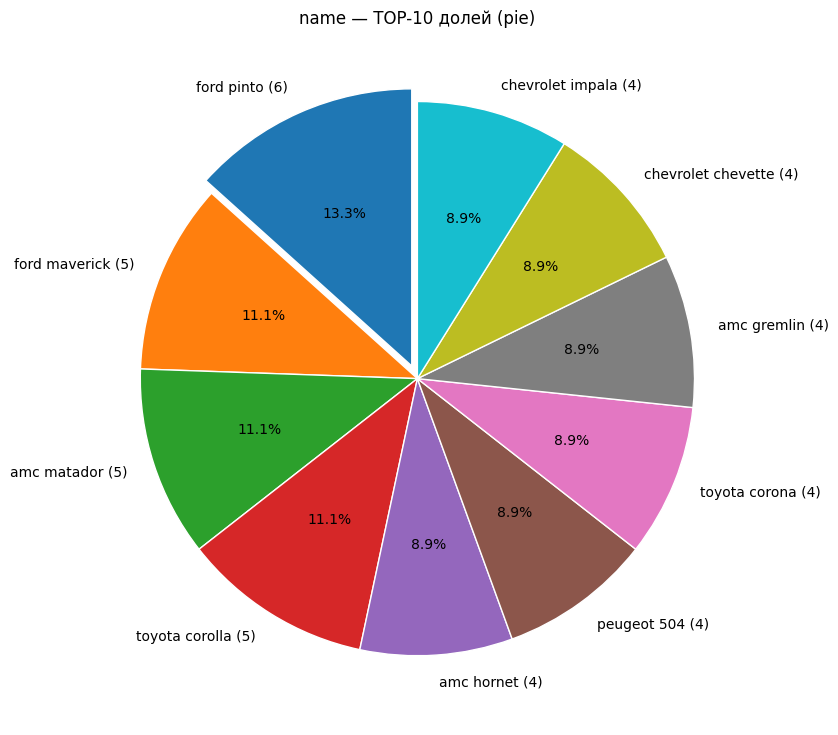

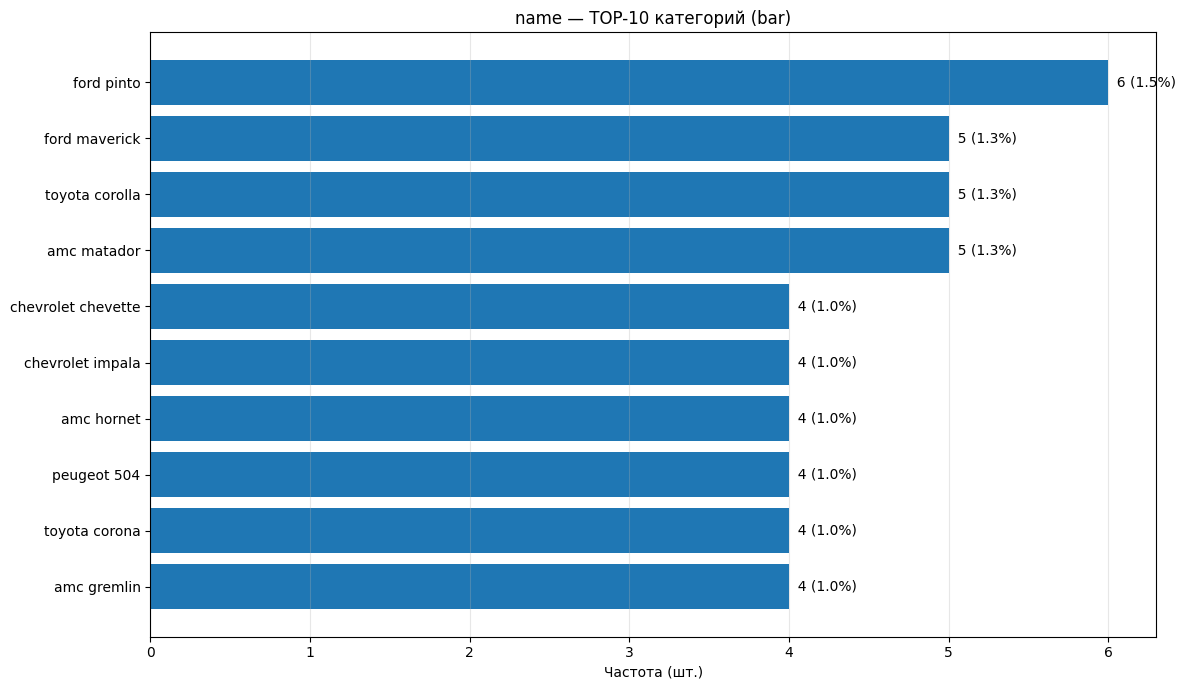

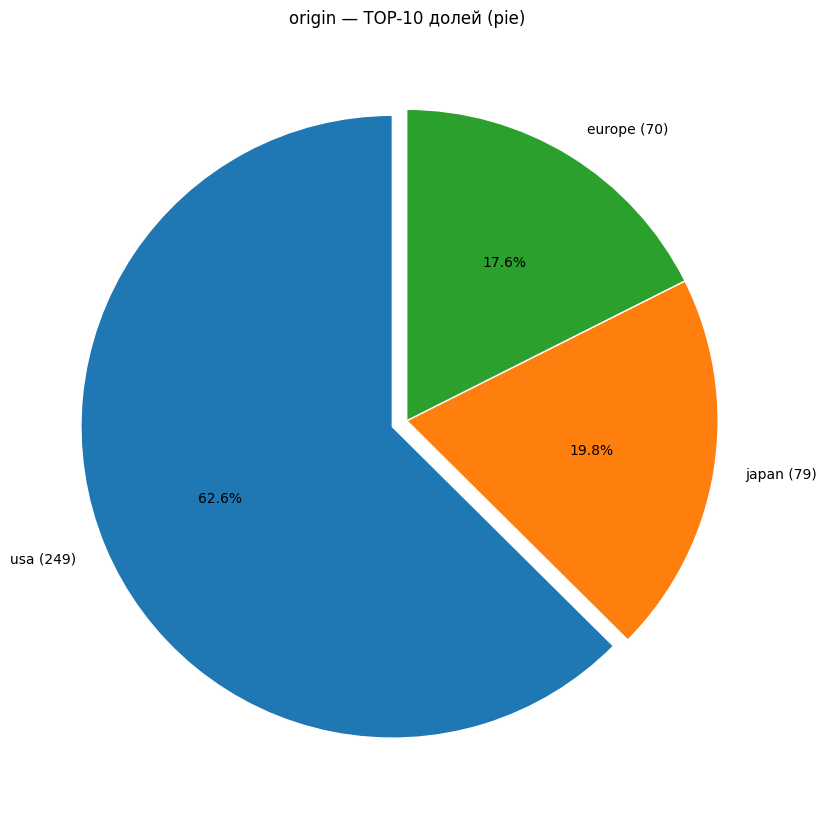

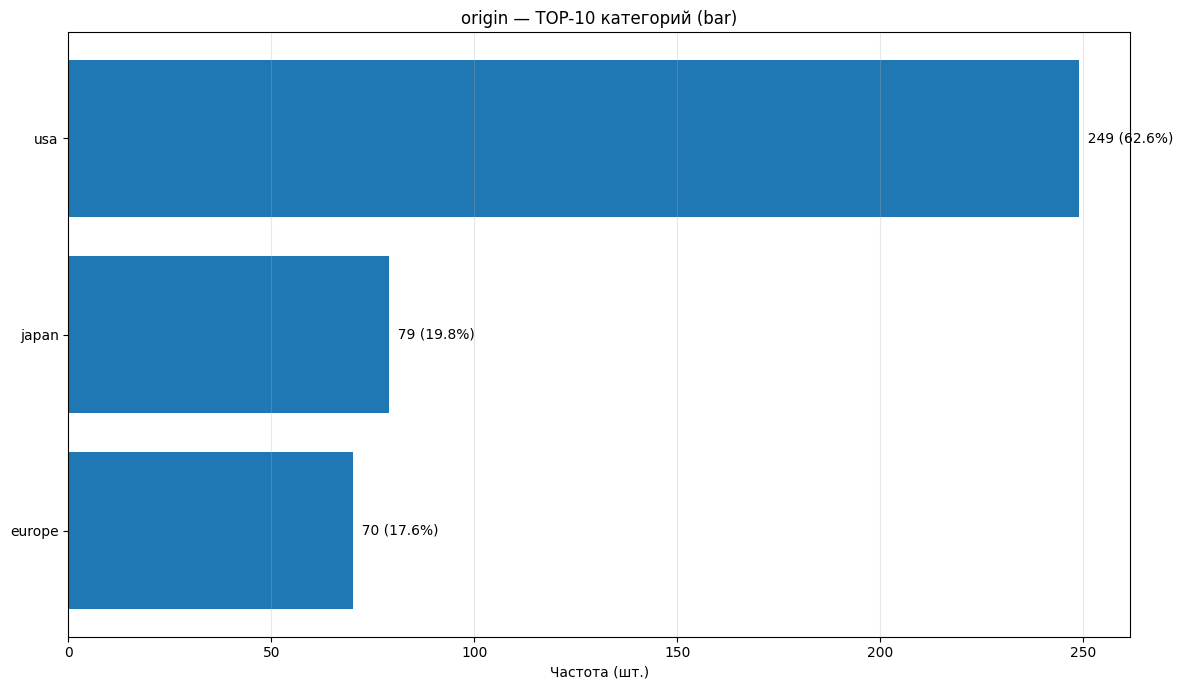

In [ ]:
# гарантируем, что список категориальных колонок есть (если не запускали предыдущую ячейку)
cat_cols = [c for c in df.columns if c not in df.select_dtypes(include=np.number).columns] if 'cat_cols' not in locals() else cat_cols  # берём все нечисловые столбцы

# для КАЖДОЙ категориальной переменной строим две визуализации TOP-10: pie и горизонтальный bar
for c in cat_cols:                                                                 # перебираем названия категориальных столбцов
    vc = df[c].value_counts(dropna=True).head(10)                                  # считаем частоты значений и берём TOP-10 по убыванию
    if vc.empty:                                                                    # если столбец пустой или все NaN —
        continue                                                                    # пропускаем его

    labels = vc.index.astype(str).tolist()                                          # приводим категории к строкам — пригодится для подписей
    counts = vc.values                                                              # массив абсолютных частот TOP-10
    pcts = (vc.values / len(df) * 100)                                              # проценты от ВСЕХ строк датафрейма (а не только от TOP-10)

    # ------------ 1) КРУГОВАЯ ДИАГРАММА (PIE) ------------
    plt.figure(figsize=(8.5, 8.5))                                                  # делаем рисунок БОЛЬШЕ и КВАДРАТНЫЙ (красивее для pie)
    labels_with_counts = [f"{lab} ({cnt})" for lab, cnt in zip(labels, counts)]     # формируем подписи «категория (шт.)»
    explode = [0.05] + [0]*(len(counts)-1)                                          # слегка «выделяем» первый сектор (самую частую категорию)
    plt.pie(counts,                                                                  # значения (сектора пропорциональны частотам)
            labels=labels_with_counts,                                               # подписи с названиями и числами
            autopct="%1.1f%%",                                                       # автоматически выводить проценты (округление до 0.1%)
            startangle=90,                                                           # начинаем с вертикали, чтобы картинка была стабильнее
            explode=explode,                                                         # небольшой «отрыв» самого большого сектора
            wedgeprops={"linewidth": 1, "edgecolor": "white"})                       # тонкие белые границы между секторами
    plt.gca().set_aspect('equal')                                                    # делаем круг идеальным (а не эллипсом)
    plt.title(f"{c} — TOP-10 долей (pie)")                                           # заголовок с названием столбца
    plt.tight_layout()                                                               # аккуратно раскладываем элементы на фигуре
    plt.show()                                                                       # показываем pie-график

    # ------------ 2) ГОРИЗОНТАЛЬНАЯ СТОЛБЧАТАЯ ДИАГРАММА (BARH) ------------
    order = np.argsort(counts)                                                       # сортируем индексы по возрастанию частот (чтобы большие были сверху)
    counts_sorted = counts[order]                                                    # отсортированные частоты
    pcts_sorted = pcts[order]                                                        # отсортированные проценты
    labels_sorted = [labels[i] for i in order]                                       # отсортированные подписи категорий

    plt.figure(figsize=(12, 7))                                                      # широкий и высокий график для удобного чтения подписей
    y_pos = np.arange(len(labels_sorted))                                            # позиции по оси Y для полос
    plt.barh(y_pos, counts_sorted)                                                   # строим горизонтальные столбцы по абсолютным частотам
    plt.yticks(y_pos, labels_sorted)                                                 # ставим метки по оси Y — названия категорий
    plt.xlabel("Частота (шт.)")                                                      # подпись оси X — абсолютные значения
    plt.title(f"{c} — TOP-10 категорий (bar)")                                       # заголовок графика

    # наносим подписи с числом и процентом справа от каждого столбца
    for i, (val, pct) in enumerate(zip(counts_sorted, pcts_sorted)):                 # идём по отсортированным полосам
        plt.text(val, i, f"  {val} ({pct:.1f}%)", va="center")                       # печатаем «шт. (проц.)» у конца столбца

    plt.grid(axis="x", alpha=0.3)                                                    # лёгкая вертикальная сетка для масштаба
    plt.tight_layout()                                                               # компактная компоновка
    plt.show()                                                                       # показываем bar-график